# Spaceship Titanic - V10 (Multi-Seed + Threshold + Blend)

**V5 = BEST LB (0.80874)**. Features et params sont au sweet spot. On exploite 3 leviers "gratuits" :

1. **Multi-seed averaging** : V5 entraîné avec 5 seeds → réduit la variance des prédictions
2. **Threshold optimization** : trouver le seuil optimal (≠ 0.50) sur les OOF predictions
3. **Submission blending** : vote majoritaire entre V5, V8, et V10 multi-seed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings, os

warnings.filterwarnings('ignore')

SEED = 42
N_FOLDS = 10
TARGET = 'Transported'
SEEDS = [42, 123, 456, 789, 2024]

def seed_everything(seed):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)
print(f'V10 Setup complete. Seeds: {SEEDS}')

V10 Setup complete. Seeds: [42, 123, 456, 789, 2024]


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

print(f'Train: {train.shape}, Test: {test.shape}')

train['is_train'] = 1
test['is_train'] = 0
test[TARGET] = np.nan
df = pd.concat([train, test], axis=0, ignore_index=True)

spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
print(f'Combined: {df.shape}')

Train: (8693, 14), Test: (4277, 13)
Combined: (12970, 15)


## Feature Engineering (V5 identique — 32 features)

In [3]:
# === V2 Feature Engineering (IDENTICAL) ===
df['_Group'] = df['PassengerId'].str.split('_').str[0].astype(int)
df['GroupSize'] = df.groupby('_Group')['PassengerId'].transform('count')
df['IsAlone'] = (df['GroupSize'] == 1).astype(int)

df['Deck'] = df['Cabin'].str.split('/').str[0]
df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype(float)
df['Side'] = df['Cabin'].str.split('/').str[2]
df['CabinRegion'] = (df['CabinNum'] // 100).astype(float)

df['Surname'] = df['Name'].str.split().str[-1]
df['FamilySize'] = df.groupby('Surname')['PassengerId'].transform('count')
df.loc[df['Surname'].isna(), 'FamilySize'] = 1

df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0, 'True': 1, 'False': 0})
df['VIP'] = df['VIP'].map({True: 1, False: 0, 'True': 1, 'False': 0})

# Imputation
for col in spend_cols:
    mask = (df['CryoSleep'] == 1) & (df[col].isna())
    df.loc[mask, col] = 0
mask = (df['CryoSleep'].isna()) & (df[spend_cols].sum(axis=1) == 0)
df.loc[mask, 'CryoSleep'] = 1
mask = (df['CryoSleep'].isna()) & (df[spend_cols].sum(axis=1) > 0)
df.loc[mask, 'CryoSleep'] = 0
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# Spending features
df['TotalSpend'] = df[spend_cols].sum(axis=1)
df['TotalSpend_log'] = np.log1p(df['TotalSpend'])
df['NoSpend'] = (df['TotalSpend'] == 0).astype(int)
df['NumServicesUsed'] = (df[spend_cols] > 0).sum(axis=1)
for col in spend_cols:
    df[f'{col}_log'] = np.log1p(df[col])
df['LuxurySpend'] = np.log1p(df['Spa'] + df['VRDeck'] + df['RoomService'])
df['BasicSpend'] = np.log1p(df['FoodCourt'] + df['ShoppingMall'])

df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 5, 12, 18, 30, 50, 80], labels=[0,1,2,3,4,5]).astype(float)
df['IsChild'] = (df['Age'] < 18).astype(float)
df['CryoSleep_NoSpend'] = ((df['CryoSleep'] == 1) & (df['TotalSpend'] == 0)).astype(int)

df['GroupSpend_mean'] = df.groupby('_Group')['TotalSpend'].transform('mean')
df['GroupSpend_mean_log'] = np.log1p(df['GroupSpend_mean'])

for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    le = LabelEncoder()
    df[col + '_le'] = le.fit_transform(df[col].astype(str))
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    freq = df[col].value_counts(normalize=True)
    df[col + '_freq'] = df[col].map(freq)

print('V2 features done.')

V2 features done.


In [4]:
# === TARGET ENCODING (V5 identique) ===
te_cols = ['HomePlanet', 'Destination', 'Deck']
SMOOTHING = 20

train_idx = df[df['is_train'] == 1].index
test_idx = df[df['is_train'] == 0].index

y_for_te = df.loc[train_idx, TARGET].map({True: 1.0, False: 0.0, 1: 1.0, 0: 0.0}).astype(float)
df.loc[train_idx, '_target_float'] = y_for_te.values
global_mean = float(y_for_te.mean())

kf_te = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for col in te_cols:
    col_te = f'{col}_te'
    df[col_te] = global_mean
    for fold_train, fold_val in kf_te.split(train_idx, y_for_te):
        fold_train_idx = train_idx[fold_train]
        fold_val_idx = train_idx[fold_val]
        stats = df.loc[fold_train_idx].groupby(col)['_target_float'].agg(['mean', 'count'])
        stats['te'] = (stats['count'] * stats['mean'] + SMOOTHING * global_mean) / (stats['count'] + SMOOTHING)
        mapped = df.loc[fold_val_idx, col].map(stats['te']).fillna(global_mean)
        df.loc[fold_val_idx, col_te] = mapped.values
    stats = df.loc[train_idx].groupby(col)['_target_float'].agg(['mean', 'count'])
    stats['te'] = (stats['count'] * stats['mean'] + SMOOTHING * global_mean) / (stats['count'] + SMOOTHING)
    mapped = df.loc[test_idx, col].map(stats['te']).fillna(global_mean)
    df.loc[test_idx, col_te] = mapped.values

df.drop('_target_float', axis=1, inplace=True)
print('Target encoding done.')

Target encoding done.


In [5]:
# === FEATURES (V5: 32 features) ===
drop_cols = [
    'PassengerId', 'Name', 'Cabin', 'Surname', 'is_train', TARGET,
    'HomePlanet', 'Destination', 'Deck', 'Side',
    '_Group', 'CabinNum',
    'TotalSpend', 'GroupSpend_mean',
] + spend_cols

features = [c for c in df.columns if c not in drop_cols]
print(f'Features: {len(features)} (should be 32)')

train_df = df[df['is_train'] == 1].copy()
test_df = df[df['is_train'] == 0].copy()

X = train_df[features].values
y = train_df[TARGET].astype(int).values
X_test = test_df[features].values

print(f'X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}')

Features: 32 (should be 32)
X: (8693, 32), y: (8693,), X_test: (4277, 32)


## Part 1: Multi-Seed Averaging (5 seeds × 3 models × 10 folds)

In [6]:
# V2 manual params
lgb_base_params = {
    'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt',
    'num_leaves': 20, 'learning_rate': 0.03, 'feature_fraction': 0.7,
    'bagging_fraction': 0.7, 'bagging_freq': 5, 'min_child_samples': 30,
    'reg_alpha': 0.5, 'reg_lambda': 2.0, 'max_depth': 5,
    'n_estimators': 5000, 'verbose': -1, 'n_jobs': -1,
}

xgb_base_params = {
    'objective': 'binary:logistic', 'eval_metric': 'logloss',
    'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.7,
    'colsample_bytree': 0.7, 'min_child_weight': 10,
    'reg_alpha': 0.5, 'reg_lambda': 2.0, 'gamma': 0.1,
    'n_estimators': 5000, 'early_stopping_rounds': 200,
    'tree_method': 'hist', 'verbosity': 0,
}

cb_base_params = {
    'iterations': 5000, 'learning_rate': 0.03, 'depth': 4,
    'l2_leaf_reg': 5.0, 'subsample': 0.7, 'colsample_bylevel': 0.7,
    'min_data_in_leaf': 30, 'verbose': 0, 'early_stopping_rounds': 200,
    'task_type': 'CPU',
}

print('Model params ready (V2 manual, proven on LB).')

Model params ready (V2 manual, proven on LB).


In [7]:
# === MULTI-SEED TRAINING ===

all_oof_lgb = []
all_oof_xgb = []
all_oof_cb = []
all_test_lgb = []
all_test_xgb = []
all_test_cb = []

for seed_i, seed in enumerate(SEEDS):
    print(f'\n{"="*60}')
    print(f'SEED {seed_i+1}/{len(SEEDS)}: {seed}')
    print(f'{"="*60}')
    
    seed_everything(seed)
    kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
    
    # --- LightGBM ---
    oof_lgb = np.zeros(len(X))
    test_lgb = np.zeros(len(X_test))
    lgb_params = {**lgb_base_params, 'random_state': seed}
    
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
        model = lgb.LGBMClassifier(**lgb_params)
        model.fit(X[tr_idx], y[tr_idx], eval_set=[(X[val_idx], y[val_idx])],
                  callbacks=[lgb.early_stopping(200, verbose=False), lgb.log_evaluation(0)])
        oof_lgb[val_idx] = model.predict_proba(X[val_idx])[:, 1]
        test_lgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    lgb_acc = accuracy_score(y, (oof_lgb > 0.5).astype(int))
    print(f'  LGB seed={seed}: CV {lgb_acc:.5f}')
    all_oof_lgb.append(oof_lgb)
    all_test_lgb.append(test_lgb)
    
    # --- XGBoost ---
    oof_xgb = np.zeros(len(X))
    test_xgb = np.zeros(len(X_test))
    xgb_params = {**xgb_base_params, 'random_state': seed}
    
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
        model = xgb.XGBClassifier(**xgb_params)
        model.fit(X[tr_idx], y[tr_idx], eval_set=[(X[val_idx], y[val_idx])], verbose=0)
        oof_xgb[val_idx] = model.predict_proba(X[val_idx])[:, 1]
        test_xgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    xgb_acc = accuracy_score(y, (oof_xgb > 0.5).astype(int))
    print(f'  XGB seed={seed}: CV {xgb_acc:.5f}')
    all_oof_xgb.append(oof_xgb)
    all_test_xgb.append(test_xgb)
    
    # --- CatBoost ---
    oof_cb = np.zeros(len(X))
    test_cb = np.zeros(len(X_test))
    
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
        model = CatBoostClassifier(**cb_base_params, random_seed=seed)
        model.fit(X[tr_idx], y[tr_idx], eval_set=(X[val_idx], y[val_idx]))
        oof_cb[val_idx] = model.predict_proba(X[val_idx])[:, 1]
        test_cb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    cb_acc = accuracy_score(y, (oof_cb > 0.5).astype(int))
    print(f'  CB  seed={seed}: CV {cb_acc:.5f}')
    all_oof_cb.append(oof_cb)
    all_test_cb.append(test_cb)

print(f'\nMulti-seed training complete: {len(SEEDS)} seeds x 3 models x {N_FOLDS} folds = {len(SEEDS)*3*N_FOLDS} models')


SEED 1/5: 42


  LGB seed=42: CV 0.81456


  XGB seed=42: CV 0.81376


  CB  seed=42: CV 0.81675

SEED 2/5: 123


  LGB seed=123: CV 0.81433


  XGB seed=123: CV 0.81330


  CB  seed=123: CV 0.81744

SEED 3/5: 456


  LGB seed=456: CV 0.81514


  XGB seed=456: CV 0.81295


  CB  seed=456: CV 0.81675

SEED 4/5: 789


  LGB seed=789: CV 0.81721


  XGB seed=789: CV 0.81502


  CB  seed=789: CV 0.81686

SEED 5/5: 2024


  LGB seed=2024: CV 0.81445


  XGB seed=2024: CV 0.81042


  CB  seed=2024: CV 0.81422

Multi-seed training complete: 5 seeds x 3 models x 10 folds = 150 models


In [8]:
# === MULTI-SEED AVERAGING ===

# Average across seeds for each model
oof_lgb_ms = np.mean(all_oof_lgb, axis=0)
oof_xgb_ms = np.mean(all_oof_xgb, axis=0)
oof_cb_ms = np.mean(all_oof_cb, axis=0)

test_lgb_ms = np.mean(all_test_lgb, axis=0)
test_xgb_ms = np.mean(all_test_xgb, axis=0)
test_cb_ms = np.mean(all_test_cb, axis=0)

# Single-seed (seed=42) for comparison = first element
lgb_single = accuracy_score(y, (all_oof_lgb[0] > 0.5).astype(int))
xgb_single = accuracy_score(y, (all_oof_xgb[0] > 0.5).astype(int))
cb_single = accuracy_score(y, (all_oof_cb[0] > 0.5).astype(int))

lgb_ms_acc = accuracy_score(y, (oof_lgb_ms > 0.5).astype(int))
xgb_ms_acc = accuracy_score(y, (oof_xgb_ms > 0.5).astype(int))
cb_ms_acc = accuracy_score(y, (oof_cb_ms > 0.5).astype(int))

print('=== MULTI-SEED vs SINGLE-SEED ===')
print(f'LGB: single={lgb_single:.5f} → multi-seed={lgb_ms_acc:.5f} ({"+" if lgb_ms_acc >= lgb_single else ""}{lgb_ms_acc - lgb_single:+.5f})')
print(f'XGB: single={xgb_single:.5f} → multi-seed={xgb_ms_acc:.5f} ({"+" if xgb_ms_acc >= xgb_single else ""}{xgb_ms_acc - xgb_single:+.5f})')
print(f'CB:  single={cb_single:.5f} → multi-seed={cb_ms_acc:.5f} ({"+" if cb_ms_acc >= cb_single else ""}{cb_ms_acc - cb_single:+.5f})')

# 3-model ensemble (multi-seed averaged)
oof_ensemble_ms = (oof_lgb_ms + oof_xgb_ms + oof_cb_ms) / 3
test_ensemble_ms = (test_lgb_ms + test_xgb_ms + test_cb_ms) / 3

# Single-seed ensemble for comparison
oof_ensemble_single = (all_oof_lgb[0] + all_oof_xgb[0] + all_oof_cb[0]) / 3
single_acc = accuracy_score(y, (oof_ensemble_single > 0.5).astype(int))
ms_acc = accuracy_score(y, (oof_ensemble_ms > 0.5).astype(int))

print(f'\nEnsemble: single-seed={single_acc:.5f} → multi-seed={ms_acc:.5f} ({ms_acc - single_acc:+.5f})')

=== MULTI-SEED vs SINGLE-SEED ===
LGB: single=0.81456 → multi-seed=0.81537 (++0.00081)
XGB: single=0.81376 → multi-seed=0.81445 (++0.00069)
CB:  single=0.81675 → multi-seed=0.81732 (++0.00058)

Ensemble: single-seed=0.81767 → multi-seed=0.81617 (-0.00150)


## Part 2: Threshold Optimization

In [9]:
# === THRESHOLD OPTIMIZATION on multi-seed OOF ===

thresholds = np.arange(0.440, 0.560, 0.001)
scores = []

for t in thresholds:
    preds = (oof_ensemble_ms > t).astype(int)
    acc = accuracy_score(y, preds)
    scores.append(acc)

scores = np.array(scores)
best_idx = np.argmax(scores)
best_threshold = thresholds[best_idx]
best_acc = scores[best_idx]

# Also check per-model thresholds
for name, oof in [('LGB', oof_lgb_ms), ('XGB', oof_xgb_ms), ('CB', oof_cb_ms), ('Ensemble', oof_ensemble_ms)]:
    best_t = 0.5
    best_a = 0
    for t in np.arange(0.440, 0.560, 0.001):
        a = accuracy_score(y, (oof > t).astype(int))
        if a > best_a:
            best_a = a
            best_t = t
    default_a = accuracy_score(y, (oof > 0.5).astype(int))
    print(f'{name:10s}: default(0.500)={default_a:.5f}  best(t={best_t:.3f})={best_a:.5f}  gain={best_a-default_a:+.5f}')

print(f'\nOptimal threshold for ensemble: {best_threshold:.3f} → accuracy {best_acc:.5f}')

LGB       : default(0.500)=0.81537  best(t=0.511)=0.81767  gain=+0.00230
XGB       : default(0.500)=0.81445  best(t=0.511)=0.81583  gain=+0.00138
CB        : default(0.500)=0.81732  best(t=0.484)=0.81916  gain=+0.00184
Ensemble  : default(0.500)=0.81617  best(t=0.525)=0.81928  gain=+0.00311

Optimal threshold for ensemble: 0.525 → accuracy 0.81928


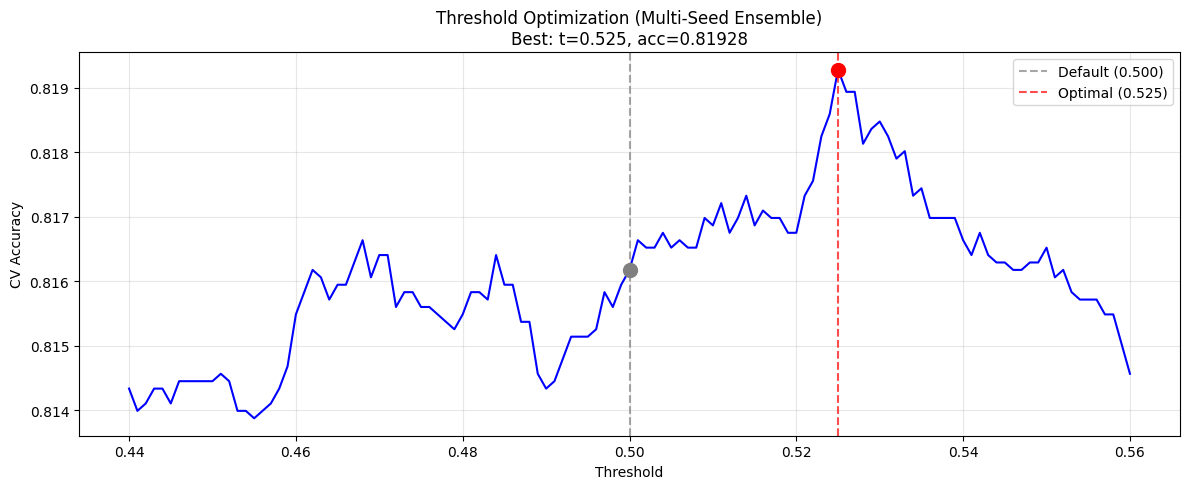

Predictions changed by threshold shift: 185 (2.1%)


In [10]:
# Visualize threshold sensitivity
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(thresholds, scores, 'b-', linewidth=1.5)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default (0.500)')
ax.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7, label=f'Optimal ({best_threshold:.3f})')
ax.scatter([best_threshold], [best_acc], color='red', s=100, zorder=5)
ax.scatter([0.5], [accuracy_score(y, (oof_ensemble_ms > 0.5).astype(int))], color='gray', s=100, zorder=5)
ax.set_xlabel('Threshold')
ax.set_ylabel('CV Accuracy')
ax.set_title(f'Threshold Optimization (Multi-Seed Ensemble)\nBest: t={best_threshold:.3f}, acc={best_acc:.5f}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# How many predictions change?
preds_default = (oof_ensemble_ms > 0.5).astype(int)
preds_optimal = (oof_ensemble_ms > best_threshold).astype(int)
n_changed = (preds_default != preds_optimal).sum()
print(f'Predictions changed by threshold shift: {n_changed} ({n_changed/len(y)*100:.1f}%)')

## Part 3: Submission Blending

In [11]:
# === LOAD EXISTING BEST SUBMISSIONS ===
sub_v5 = pd.read_csv('../submissions/submission_v5.csv')
sub_v8 = pd.read_csv('../submissions/submission_v8.csv')  # 5-model, LB 0.80851

# Convert to int
v5_preds = sub_v5['Transported'].astype(int).values
v8_preds = sub_v8['Transported'].astype(int).values

# V10 predictions (multi-seed, default threshold)
v10_preds_default = (test_ensemble_ms > 0.5).astype(int)
v10_preds_optimal = (test_ensemble_ms > best_threshold).astype(int)

print('=== SUBMISSION COMPARISON ===')
print(f'V5  (LB 0.80874): True={v5_preds.sum()}, False={len(v5_preds)-v5_preds.sum()}')
print(f'V8  (LB 0.80851): True={v8_preds.sum()}, False={len(v8_preds)-v8_preds.sum()}')
print(f'V10 (t=0.500):    True={v10_preds_default.sum()}, False={len(v10_preds_default)-v10_preds_default.sum()}')
print(f'V10 (t={best_threshold:.3f}):    True={v10_preds_optimal.sum()}, False={len(v10_preds_optimal)-v10_preds_optimal.sum()}')

# Pairwise agreement
print(f'\n=== PAIRWISE AGREEMENT ===')
print(f'V5  vs V8:  {(v5_preds == v8_preds).mean():.4f} ({(v5_preds != v8_preds).sum()} diffs)')
print(f'V5  vs V10: {(v5_preds == v10_preds_default).mean():.4f} ({(v5_preds != v10_preds_default).sum()} diffs)')
print(f'V8  vs V10: {(v8_preds == v10_preds_default).mean():.4f} ({(v8_preds != v10_preds_default).sum()} diffs)')

=== SUBMISSION COMPARISON ===
V5  (LB 0.80874): True=2212, False=2065
V8  (LB 0.80851): True=2213, False=2064
V10 (t=0.500):    True=2209, False=2068
V10 (t=0.525):    True=2109, False=2168

=== PAIRWISE AGREEMENT ===
V5  vs V8:  0.9792 (89 diffs)
V5  vs V10: 0.9960 (17 diffs)
V8  vs V10: 0.9780 (94 diffs)


In [12]:
# === MAJORITY VOTING BLENDS ===

# Blend 1: V5 + V8 + V10(default) — 3-way majority vote
votes_3way = v5_preds + v8_preds + v10_preds_default
blend_3way = (votes_3way >= 2).astype(int)  # majority = 2 out of 3

# Blend 2: V5 + V8 + V10(optimal threshold)
votes_3way_opt = v5_preds + v8_preds + v10_preds_optimal
blend_3way_opt = (votes_3way_opt >= 2).astype(int)

# How different from V5?
print('=== MAJORITY VOTE BLENDS ===')
diff_3way = (blend_3way != v5_preds).sum()
diff_3way_opt = (blend_3way_opt != v5_preds).sum()
print(f'Blend(V5+V8+V10 default):  {diff_3way} diffs from V5 ({diff_3way/len(v5_preds)*100:.1f}%)')
print(f'Blend(V5+V8+V10 optimal):  {diff_3way_opt} diffs from V5 ({diff_3way_opt/len(v5_preds)*100:.1f}%)')

# Where do all 3 agree vs disagree?
all_agree = (votes_3way == 0) | (votes_3way == 3)
print(f'\nAll 3 agree: {all_agree.sum()} ({all_agree.mean()*100:.1f}%)')
print(f'Disagreement: {(~all_agree).sum()} ({(~all_agree).mean()*100:.1f}%)')

=== MAJORITY VOTE BLENDS ===
Blend(V5+V8+V10 default):  6 diffs from V5 (0.1%)
Blend(V5+V8+V10 optimal):  29 diffs from V5 (0.7%)

All 3 agree: 4177 (97.7%)
Disagreement: 100 (2.3%)


## Generate All Submissions

In [13]:
def save_submission(preds_int, filename, description):
    sub = pd.DataFrame({
        'PassengerId': test_df['PassengerId'].values,
        'Transported': preds_int.astype(bool)
    })
    sub.to_csv(f'../submissions/{filename}', index=False)
    assert sub.shape[0] == sample_sub.shape[0]
    assert list(sub.columns) == list(sample_sub.columns)
    print(f'{filename:40s} | {description}')
    print(f'  True={preds_int.sum()}, False={len(preds_int)-preds_int.sum()}, Ratio={preds_int.mean():.4f}')
    return sub

print('=== GENERATING SUBMISSIONS ===')
print()

# 1. Multi-seed, default threshold
save_submission(v10_preds_default, 'submission_v10_multiseed.csv',
                f'Multi-seed(5 seeds), t=0.500, CV={ms_acc:.5f}')
print()

# 2. Multi-seed, optimal threshold
save_submission(v10_preds_optimal, 'submission_v10_optimal_t.csv',
                f'Multi-seed(5 seeds), t={best_threshold:.3f}, CV={best_acc:.5f}')
print()

# 3. Majority vote blend (V5 + V8 + V10)
save_submission(blend_3way, 'submission_v10_blend.csv',
                'Majority vote: V5 + V8 + V10(default)')
print()

# 4. Majority vote blend with optimal threshold
save_submission(blend_3way_opt, 'submission_v10_blend_opt.csv',
                f'Majority vote: V5 + V8 + V10(t={best_threshold:.3f})')

=== GENERATING SUBMISSIONS ===

submission_v10_multiseed.csv             | Multi-seed(5 seeds), t=0.500, CV=0.81617
  True=2209, False=2068, Ratio=0.5165

submission_v10_optimal_t.csv             | Multi-seed(5 seeds), t=0.525, CV=0.81928
  True=2109, False=2168, Ratio=0.4931

submission_v10_blend.csv                 | Majority vote: V5 + V8 + V10(default)
  True=2214, False=2063, Ratio=0.5177

submission_v10_blend_opt.csv             | Majority vote: V5 + V8 + V10(t=0.525)
  True=2183, False=2094, Ratio=0.5104


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [14]:
print('\n' + '='*70)
print('FINAL SUMMARY')
print('='*70)
print(f'\nMulti-seed ensemble CV:          {ms_acc:.5f} (vs V5 single-seed: {single_acc:.5f})')
print(f'Optimal threshold:               {best_threshold:.3f} (CV: {best_acc:.5f})')
print(f'Predictions changed by threshold: {n_changed}')
print(f'\nSubmission files generated: 4')
print(f'  1. submission_v10_multiseed.csv  — safest (multi-seed, t=0.500)')
print(f'  2. submission_v10_optimal_t.csv  — best CV (multi-seed, t={best_threshold:.3f})')
print(f'  3. submission_v10_blend.csv      — consensus (V5+V8+V10 majority vote)')
print(f'  4. submission_v10_blend_opt.csv  — consensus + optimal threshold')
print(f'\nRecommendation: Submit #3 (blend) first — it leverages the proven V5 and V8 submissions')
print(f'                Then #1 (multi-seed) as backup')


FINAL SUMMARY

Multi-seed ensemble CV:          0.81617 (vs V5 single-seed: 0.81767)
Optimal threshold:               0.525 (CV: 0.81928)
Predictions changed by threshold: 185

Submission files generated: 4
  1. submission_v10_multiseed.csv  — safest (multi-seed, t=0.500)
  2. submission_v10_optimal_t.csv  — best CV (multi-seed, t=0.525)
  3. submission_v10_blend.csv      — consensus (V5+V8+V10 majority vote)
  4. submission_v10_blend_opt.csv  — consensus + optimal threshold

Recommendation: Submit #3 (blend) first — it leverages the proven V5 and V8 submissions
                Then #1 (multi-seed) as backup
